In [1]:
import numpy as np
import os,sys


sys.path.append('../../../Env')
sys.path.append('../../../Imaging')
sys.path.append('../../../../RL_lib/Agents/PPO')
sys.path.append('../../../../RL_lib/Utils')
%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_repo/Exo_intercept/Experiments/EKV/Test_PN


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 6.123234e-17  0.000000e+00 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  0.000000e+00  6.123234e-17]]
[1.000000e+00 0.000000e+00 6.123234e-17]
using max  pooling
Angle sensor:
	Output State type:  <function Angle_sensor.optflow_state at 0x154cfa2f0>
	Offset Init type:  <function Angle_sensor.offset_init1 at 0x154cf2ea0>
	Fixed Offset:  None
3dof dynamics model
3-dof Actuator Model:  49.050000000000004
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Target Model: 
 - foo:  0.0
6dof dynamics model
thruster model:  [4905. 4905. 4905. 4905.]
Rotational Velocity Constraint
Attitude Constraint
Inertia Tensor:  [[1.04166667 0.         0.        ]
 [0.         7.29166667 0.        ]
 [0.         0.         7.29166667]]
Missile Model: 
 - foo:  0.0
Reward_terminal


<IPython.core.display.Javascript object>


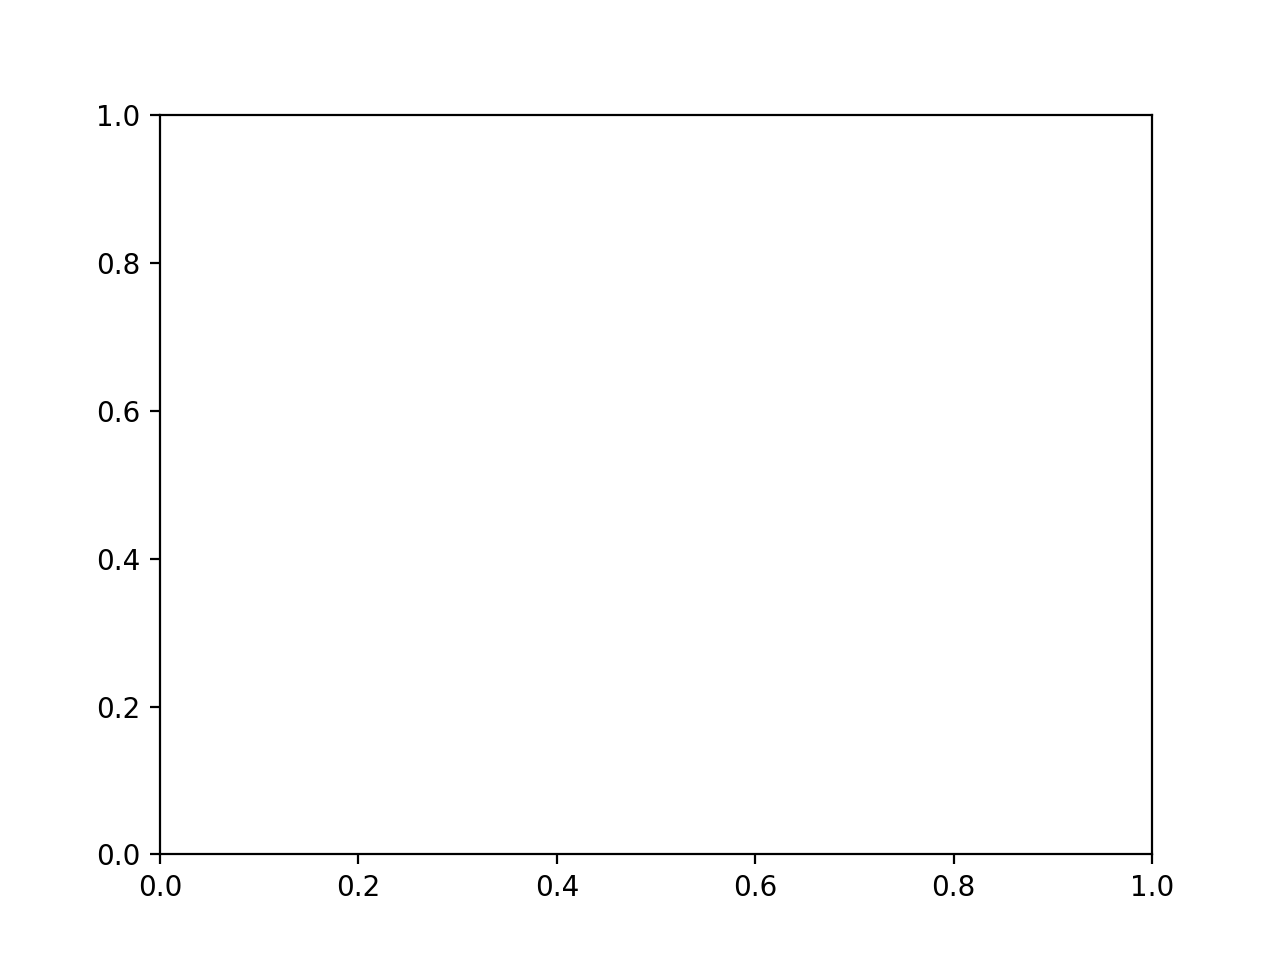

<IPython.core.display.Javascript object>


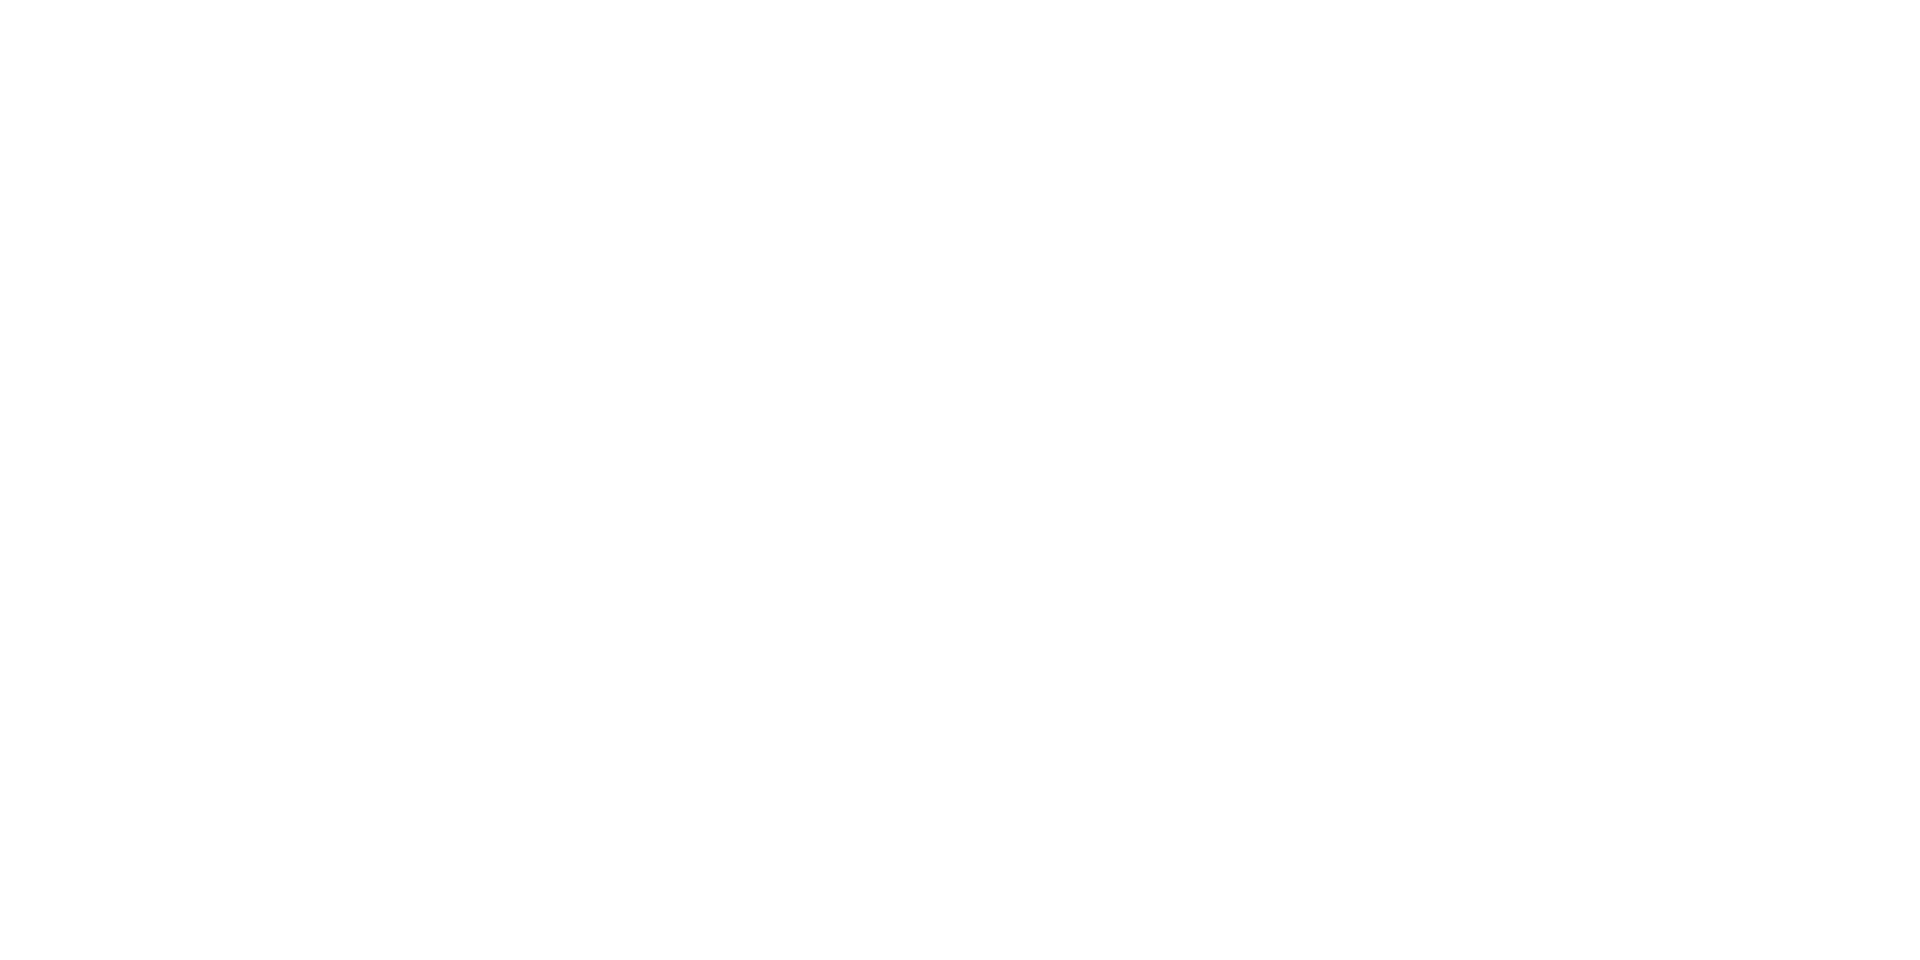

<IPython.core.display.Javascript object>


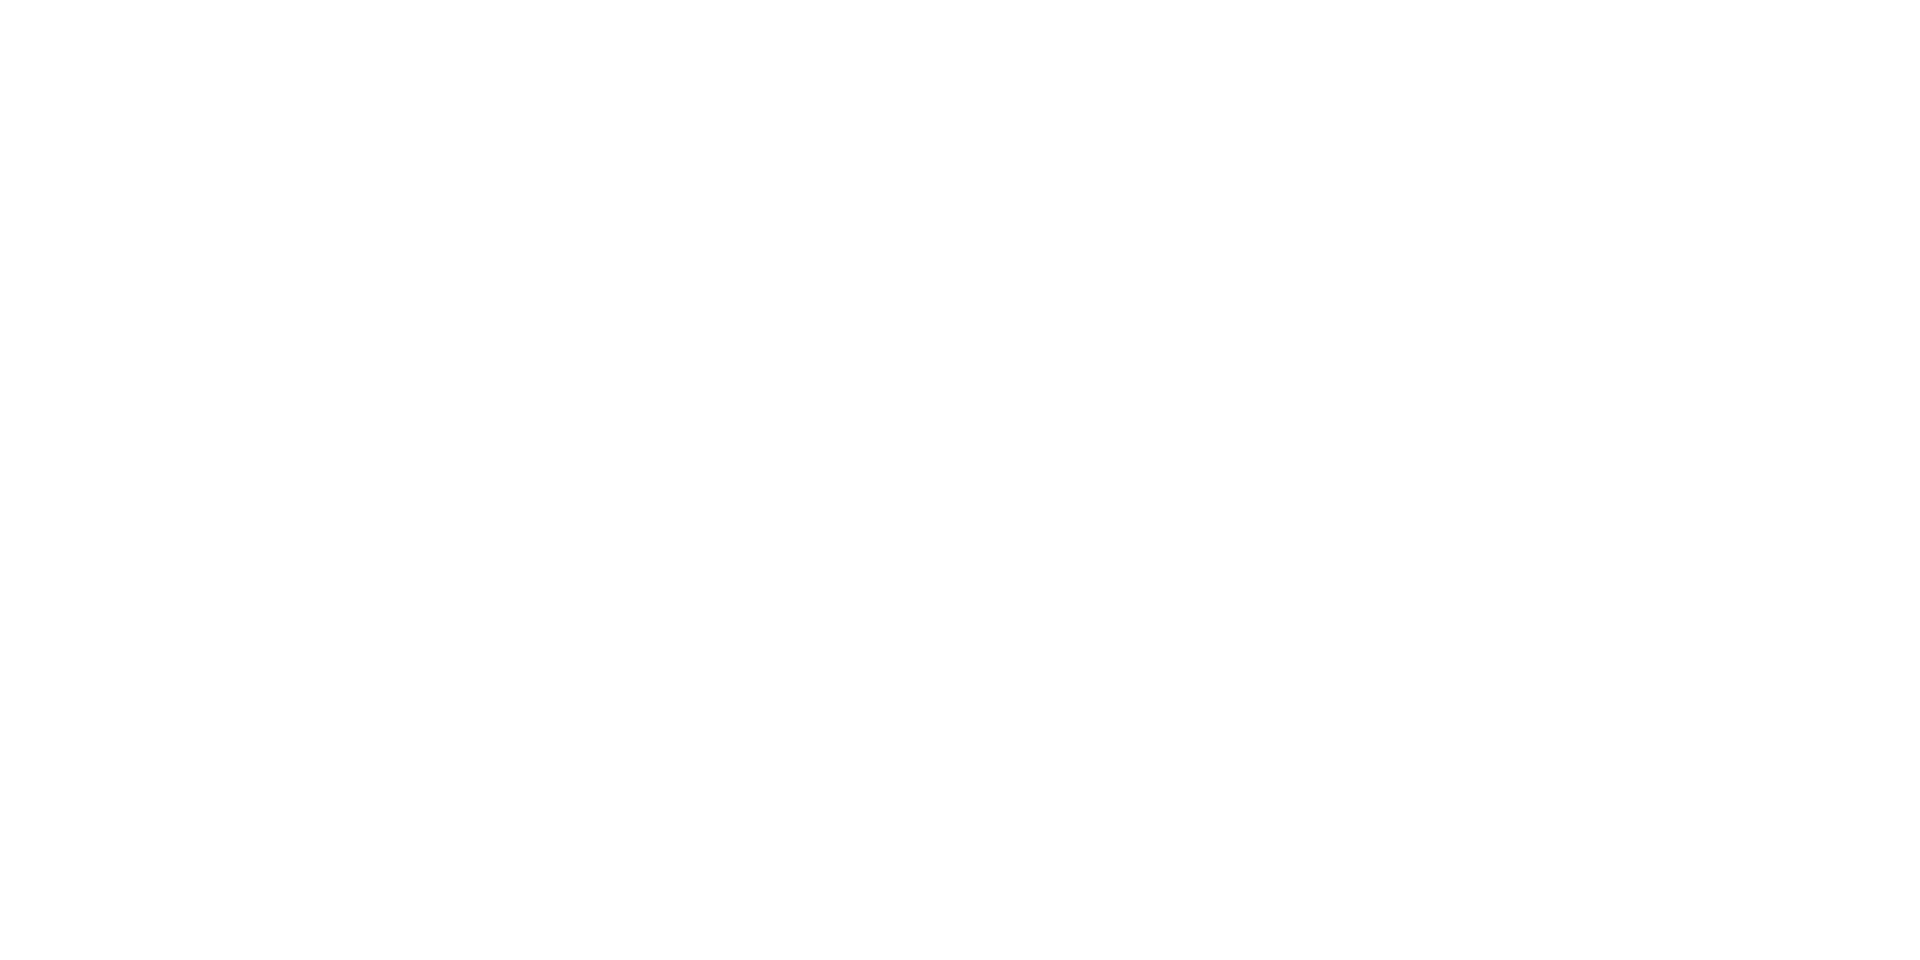

<IPython.core.display.Javascript object>


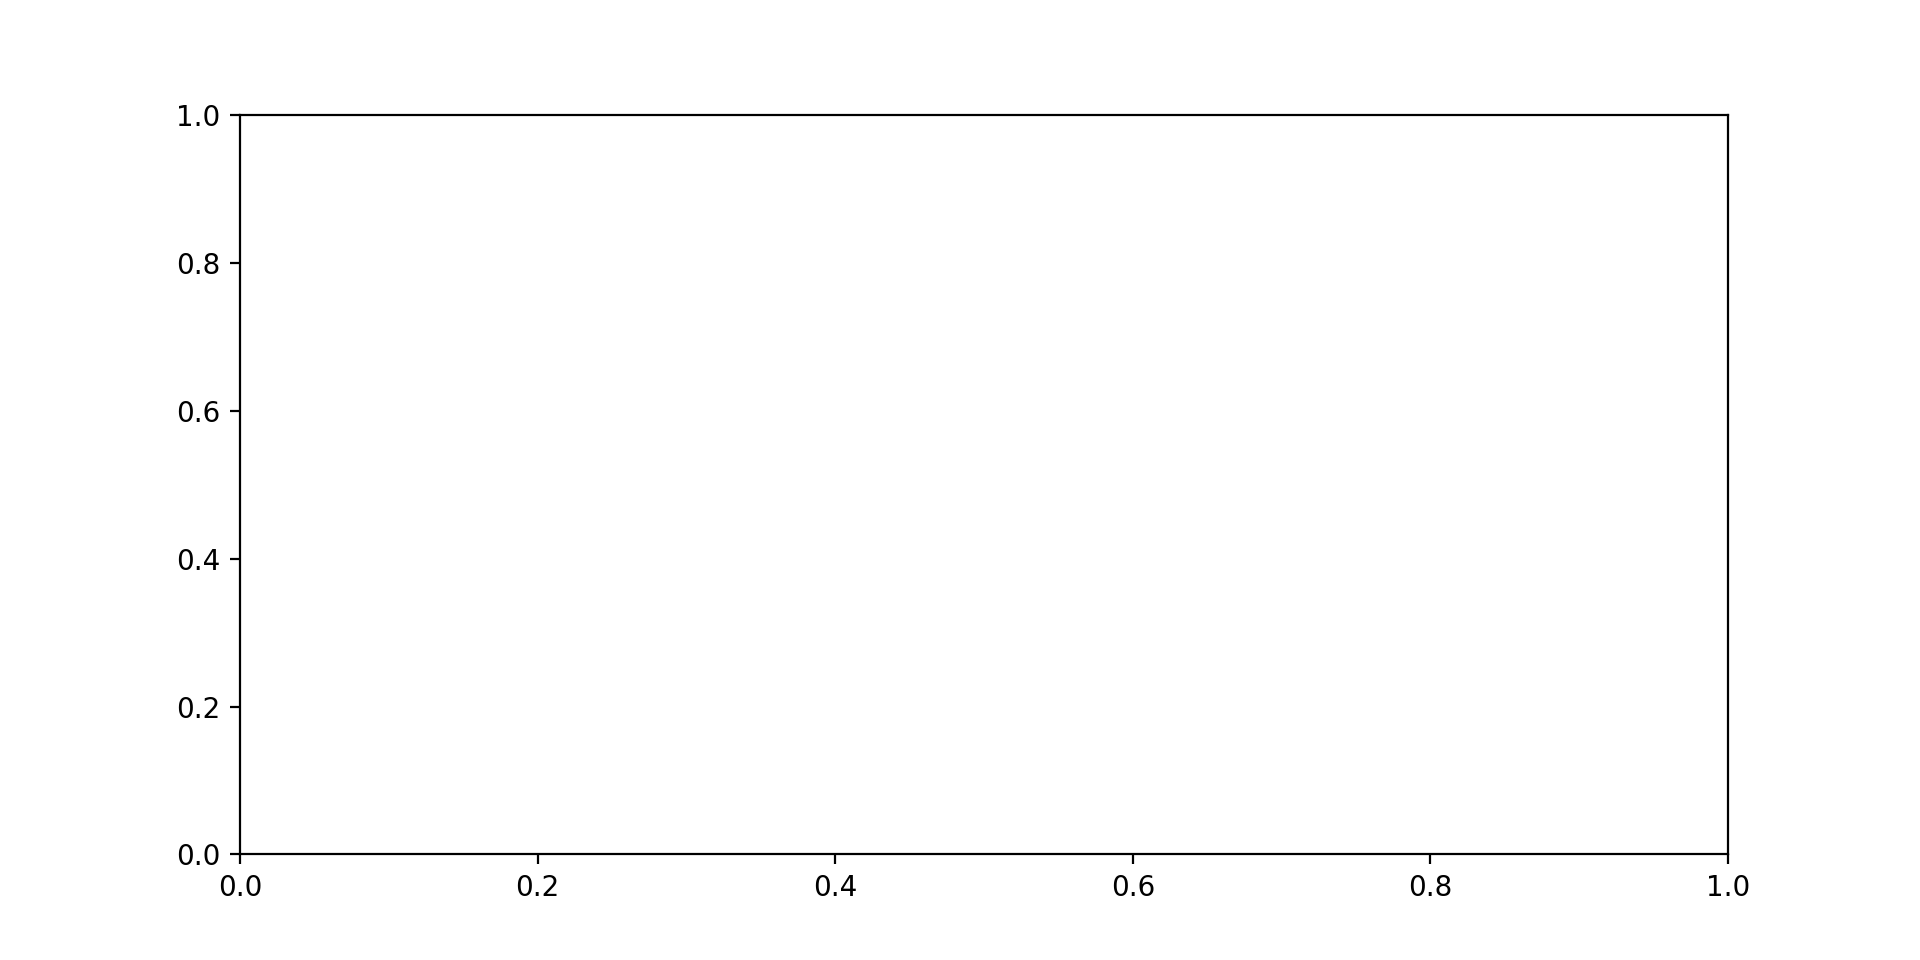

Missile env fixed (h= 0.02
Value Funtion
	xn_init: layer  Linear(in_features=19, out_features=190, bias=True)
	xn_init: layer  GRUCell(190, 30)
	xn_init: layer  Linear(in_features=30, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    200
	Rollout Limit:      1
Agent


In [4]:
from env import Env
import env_utils as envu
from reward_sensor_gaussian_of import Reward

import attitude_utils as attu

from missile import Missile
from target import Target

from missile_icgen import Missile_icgen
from target_icgen import Target_icgen

from dynamics_model_3dof import Dynamics_model_3dof as Target_dynamics_model
from dynamics_model_6dof import Dynamics_model_6dof as Missile_dynamics_model

from bangbang_policy_ra import BangBang_policy as Target_policy

from no_att_constraint import No_att_constraint
from no_w_constraint import No_w_constraint

######### RL vs PN ###########

is_RL = False

########## RL ###########

import rl_utils
from arch_policy_vf import Arch
import policy_nets as policy_nets
import valfunc_nets as vf_nets
from agent import Agent
from value_function import Value_function

if is_RL:
    from policy import Policy
    from softmax_pd import Softmax_pd as PD
else:
    from zem_policy import ZEM_policy as Policy
    
######### Actuator Models #########

from actuator_model_ekv import Actuator_model_ekv as Missile_actuator_model 
from actuator_model_3dof import Actuator_model_3dof as Target_actuator_model

######## Sensor ##############

from angle_sensor import Angle_sensor
from eo_model import EO_model
import optics_utils as optu

ap = attu.Quaternion_attitude()

offset=np.asarray([0,0])
C_cb = optu.rotate_optical_axis(0.0, np.pi/2, 0.0)
r_cb = np.asarray([0,0,0])
fov=np.pi-np.pi/8
cm = EO_model(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb, 
                   fov=fov, debug=False, p_x=96,p_y=96)
sensor = Angle_sensor(cm, attitude_parameterization=ap,  use_range=True, ignore_fov_vio=not is_RL,
                      use_ideal_offset=False,
                      pool_type='max', state_type=Angle_sensor.optflow_state, optflow_scale=0.1)


########## Target ############

target_voffset = 15
target_max_acc = 5*9.81
target_max_acc_range = (0., target_max_acc)
target_dynamics_model = Target_dynamics_model(h=0.02,M=1e3)
target_actuator_model = Target_actuator_model(max_acc=target_max_acc)
target_policy = Target_policy(3,max_acc_range=target_max_acc_range,tf=80)
target = Target(target_policy, target_actuator_model, target_dynamics_model, attitude_parameterization=ap)

target_icgen = Target_icgen(attitude_parameterization=ap,
                            min_init_position=(0.0, 0.0, 50000.),
                            max_init_position=(0.0, 0.0, 50000.),
                            v_mag=(3000., 4000.),
                            v_theta=(envu.deg2rad(90-target_voffset), envu.deg2rad(90+target_voffset)),
                            v_phi=(envu.deg2rad(-target_voffset), envu.deg2rad(target_voffset)))

########## Missile  #############

missile_roffset = 20
missile_mass = 50
missile_max_thrust =  10*9.81*missile_mass

missile_dynamics_model = Missile_dynamics_model(h=0.02,M=1e3)

missile_actuator_model = Missile_actuator_model(max_thrust=missile_max_thrust,pulsed=True)
missile = Missile(target, missile_actuator_model, missile_dynamics_model, sensor=sensor, 
                  attitude_parameterization=ap,
                  w_constraint=No_w_constraint(), att_constraint=No_att_constraint(ap),
                 align_cv=False, debug_cv=False, perturb_pn_velocity=True)
if not is_RL:
    missile.get_state_agent = missile.get_state_agent_PN_att
    
missile_icgen = Missile_icgen(attitude_parameterization=ap,
                           position_r=(50000.,55000.),
                           position_theta=(envu.deg2rad(90-missile_roffset),envu.deg2rad(90+missile_roffset)),
                           position_phi=(envu.deg2rad(-missile_roffset),envu.deg2rad(missile_roffset)),
                           mag_v=(3000,4000),
                           heading_error=(envu.deg2rad(0),envu.deg2rad(5)),
                           attitude_error=(0.0,0.0),
                           debug=False)


reward_object = Reward(debug=False, hit_coeff=10., tracking_coeff=1., tracking_sigma=0.10, optflow_sigma=0.004, 
                       fuel_coeff=0.0, fov_coeff=-0., hit_rlimit=0.5)

logger = rl_utils.Logger()

env = Env(missile, target, missile_icgen, target_icgen,  logger, 
          precision_range=1000., precision_scale=300, terminate_on_vc=not is_RL,
          reward_object=reward_object, use_offset=False, debug_steps=True,
          tf_limit=50.0,print_every=10,nav_period=0.10)

                

##########################################
recurrent_steps = 200
if is_RL:
    obs_dim = 4
    action_dim = 4
    actions_per_dim = 2
    logit_dim = action_dim * actions_per_dim
    policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
else:
    policy = Policy(ap=ap,  max_acc=missile_max_thrust / missile_mass)
    obs_dim = 19
    act_dim = 4
    
arch = Arch()

value_function = Value_function(vf_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.90, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)




# Test Policy 


In [5]:

env.test_policy_batch(agent,5000,print_every=100,test_mode=True)

worked 1
Dynamics: Max Disturbance (m/s^2):  [1.73060319e-12 8.63778015e-14 1.18742537e-12] 2.1005779085312366e-12
Dynamics: Max Disturbance (m/s^2):  [0.0000e+00 0.0000e+00 2.6696e-12] 2.6695999999999994e-12
i (et): 100  (             241)
Cumulative Stats (mean,std,max,argmax)
thrust   |2481.17 |2765.41 |  0.00 |6936.72 |    67
 
Final Stats (mean,std,min,max)
hit_reward |     5.1 |     5.0 |     0.0 |    10.0
hit_100cm |    0.98 |    0.14 |    0.00 |    1.00
hit_50cm |    0.51 |    0.50 |    0.00 |    1.00
norm_vf  |6591.338 | 461.517 |4921.666 |7608.543
norm_rf  |     0.5 |     0.2 |     0.1 |     1.1
position | 27587.6  -104.7 49558.6 |  2596.9  4135.6  4374.7 | 22486.9 -8228.3 41276.9 | 33945.8  7838.2 57823.1
velocity |-2907.901 -92.002  44.255 | 491.5571262.0331343.394 |-3861.826-2198.236-2507.952 |-1708.1262674.5042734.361
fuel     | 10.94 |  4.32 |  3.22 | 20.76
attitude_321 |  -0.113  -0.008   0.217 |   2.791   0.429   1.779 |  -3.107  -0.857  -3.056 |   3.134   0.888   3.08

i (et): 900  (             241)
Cumulative Stats (mean,std,max,argmax)
thrust   |2364.33 |2729.76 |  0.00 |6936.72 |    67
 
Final Stats (mean,std,min,max)
hit_reward |     4.9 |     5.0 |     0.0 |    10.0
hit_100cm |    0.98 |    0.14 |    0.00 |    1.00
hit_50cm |    0.49 |    0.50 |    0.00 |    1.00
norm_vf  |6589.432 | 510.910 |4533.615 |7861.542
norm_rf  |     0.5 |     0.3 |     0.0 |     4.6
position | 27425.8     3.3 49895.7 |  2616.6  4240.9  4246.9 | 20966.7-10598.7 38599.1 | 41879.3  9531.8 59409.2
velocity |-2912.610 -14.652  15.467 | 524.7891320.3881352.067 |-3966.444-2945.028-3042.079 |-443.4662868.2812996.527
fuel     | 10.32 |  3.74 |  0.87 | 20.76
attitude_321 |  -0.045  -0.003   0.086 |   2.780   0.418   1.729 |  -3.141  -1.065  -3.128 |   3.141   1.013   3.140
w        |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000
Dynamics: Max Disturbance (m/s^2):  [1.89628249e-12 6.28818441e-13 2.36265808e-12] 3.0940997287

Dynamics: Max Disturbance (m/s^2):  [1.90468161e-12 6.28818441e-13 2.38468518e-12] 3.116078963553013e-12
Dynamics: Max Disturbance (m/s^2):  [1.66563898e-12 4.21533149e-13 2.71661912e-12] 3.2143526309609953e-12
i (et): 1700  (             250)
Cumulative Stats (mean,std,max,argmax)
thrust   |2376.68 |2735.97 |  0.00 |6936.72 |    67
 
Final Stats (mean,std,min,max)
hit_reward |     4.8 |     5.0 |     0.0 |    10.0
hit_100cm |    0.98 |    0.13 |    0.00 |    1.00
hit_50cm |    0.48 |    0.50 |    0.00 |    1.00
norm_vf  |6577.901 | 514.600 |4533.615 |7867.168
norm_rf  |     0.5 |     0.3 |     0.0 |     4.6
position | 27409.4    22.5 49994.3 |  2607.0  4208.9  4310.6 | 20966.7-10598.7 38599.1 | 41879.3  9531.8 59817.7
velocity |-2902.532 -23.250  31.360 | 526.8351323.3771368.123 |-3982.785-3043.023-3042.079 |-443.4662868.2812996.527
fuel     | 10.41 |  3.72 |  0.87 | 20.76
attitude_321 |  -0.089  -0.008   0.058 |   2.777   0.420   1.752 |  -3.141  -1.065  -3.137 |   3.141   1.013   3.

Dynamics: Max Disturbance (m/s^2):  [1.90468161e-12 6.28818441e-13 2.38468518e-12] 3.116078963553013e-12
Dynamics: Max Disturbance (m/s^2):  [1.66563898e-12 4.21533149e-13 2.71823436e-12] 3.2157178702890472e-12
i (et): 2500  (             250)
Cumulative Stats (mean,std,max,argmax)
thrust   |2388.97 |2735.02 |  0.00 |6936.72 |    67
 
Final Stats (mean,std,min,max)
hit_reward |     4.8 |     5.0 |     0.0 |    10.0
hit_100cm |    0.98 |    0.15 |    0.00 |    1.00
hit_50cm |    0.48 |    0.50 |    0.00 |    1.00
norm_vf  |6573.559 | 512.179 |4533.615 |7867.168
norm_rf  |     0.5 |     0.3 |     0.0 |     4.6
position | 27442.4     0.4 50059.1 |  2609.7  4181.1  4302.9 | 20966.7-10598.7 38599.1 | 41879.3  9604.3 59817.7
velocity |-2898.627 -33.948  36.383 | 525.2501324.1651366.388 |-3982.785-3043.023-3042.079 |-443.4662868.2812996.527
fuel     | 10.46 |  3.74 |  0.87 | 21.12
attitude_321 |  -0.108  -0.010   0.033 |   2.773   0.419   1.743 |  -3.141  -1.065  -3.137 |   3.141   1.013   3.

Dynamics: Max Disturbance (m/s^2):  [1.90468161e-12 6.28818441e-13 2.41881687e-12] 3.142276201349457e-12
Dynamics: Max Disturbance (m/s^2):  [1.66563898e-12 4.21533149e-13 2.71823436e-12] 3.2157178702890472e-12
i (et): 3300  (             242)
Cumulative Stats (mean,std,max,argmax)
thrust   |2395.68 |2737.24 |  0.00 |6936.72 |    67
 
Final Stats (mean,std,min,max)
hit_reward |     4.8 |     5.0 |     0.0 |    10.0
hit_100cm |    0.98 |    0.16 |    0.00 |    1.00
hit_50cm |    0.48 |    0.50 |    0.00 |    1.00
norm_vf  |6576.299 | 512.362 |4533.615 |7915.789
norm_rf  |     0.5 |     0.2 |     0.0 |     4.6
position | 27433.2   -65.8 49994.9 |  2600.5  4156.4  4310.4 | 20839.7-10598.7 38599.1 | 41879.3  9604.3 60061.5
velocity |-2900.226 -45.413  48.919 | 521.9011330.0781365.885 |-3982.785-3043.023-3042.079 |-443.4662892.8202996.527
fuel     | 10.49 |  3.77 |  0.87 | 21.72
attitude_321 |  -0.113  -0.014   0.054 |   2.770   0.418   1.733 |  -3.141  -1.065  -3.137 |   3.141   1.013   3.

Dynamics: Max Disturbance (m/s^2):  [1.90468161e-12 6.39658488e-13 2.41881687e-12] 3.144463400227023e-12
Dynamics: Max Disturbance (m/s^2):  [1.66563898e-12 4.21533149e-13 2.71945918e-12] 3.2167532726984635e-12
i (et): 4100  (             244)
Cumulative Stats (mean,std,max,argmax)
thrust   |2404.41 |2737.72 |  0.00 |6936.72 |    67
 
Final Stats (mean,std,min,max)
hit_reward |     4.8 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.16 |    0.00 |    1.00
hit_50cm |    0.48 |    0.50 |    0.00 |    1.00
norm_vf  |6575.958 | 512.697 |4533.615 |7915.789
norm_rf  |     0.5 |     0.2 |     0.0 |     4.6
position | 27445.0   -93.3 49988.5 |  2581.8  4178.9  4307.6 | 20839.7-10598.7 38599.1 | 41879.3  9604.3 60061.5
velocity |-2898.316 -50.924  42.330 | 519.7561334.7641369.219 |-3982.785-3043.023-3042.079 |-443.4663079.4473046.123
fuel     | 10.53 |  3.77 |  0.87 | 21.72
attitude_321 |  -0.111  -0.011   0.047 |   2.769   0.418   1.736 |  -3.141  -1.065  -3.140 |   3.141   1.013   3.

i (et): 4900  (             237)
Cumulative Stats (mean,std,max,argmax)
thrust   |2398.05 |2735.37 |  0.00 |6936.72 |    67
 
Final Stats (mean,std,min,max)
hit_reward |     4.8 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.16 |    0.00 |    1.00
hit_50cm |    0.48 |    0.50 |    0.00 |    1.00
norm_vf  |6569.410 | 517.237 |4533.615 |7915.789
norm_rf  |     0.5 |     0.2 |     0.0 |     4.6
position | 27449.8  -101.9 49950.9 |  2571.4  4198.2  4320.7 | 20839.7-10598.7 38599.1 | 41879.3  9604.3 60061.5
velocity |-2892.956 -49.094  27.438 | 519.3241350.4111369.949 |-3982.785-3043.023-3042.079 |-443.4663079.4473046.123
fuel     | 10.51 |  3.75 |  0.87 | 21.72
attitude_321 |  -0.099  -0.007   0.030 |   2.764   0.419   1.728 |  -3.141  -1.065  -3.140 |   3.141   1.013   3.140
w        |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000
Dynamics: Max Disturbance (m/s^2):  [1.90468161e-12 6.43035673e-13 2.41881687e-12] 3.145152138